# **RNN 실습**

이번 실습에서는 짧은 영어 텍스트를 RNN에 학습시키고, 모델이 학습한 문장을 다시 출력하도록 해보겠습니다.

In [1]:
# 필요한 모델들을 import 합니다.
# 본 실습에서는 PyTorch를 이용해 RNN을 구현했습니다.

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [2]:
# 변수에 짧은 길이의 영어 텍스트를 할당하고, 중복되는 문자들은 제거하여 모든 문자가 한 번씩만 등장하도록 만들어줍니다.
# 이후 각 문자에 고유한 번호를 부여해줍니다.

sentence = "if you want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea."
char_set = list(set(sentence)) # 중복을 제거한 문자 집합 생성
char_dic = {c: i for i, c in enumerate(char_set)} # 각 문자에 정수 인코딩


In [ ]:
print(char_dic) # 공백도 여기서는 하나의 원소로 취급됩니다.

{'l': 0, 't': 1, 'h': 2, 'b': 3, '.': 4, 'm': 5, 's': 6, 'o': 7, 'p': 8, 'i': 9, 'e': 10, ' ': 11, ',': 12, 'n': 13, 'f': 14, 'g': 15, 'u': 16, 'a': 17, 'w': 18, "'": 19, 'd': 20, 'y': 21, 'r': 22, 'c': 23, 'k': 24}


In [3]:
# 문자 집합에 총 몇 개의 문자들이 존재하는지 확인해봅시다.

dic_size = len(char_dic)
print('문자 집합의 크기 : {}'.format(dic_size))

문자 집합의 크기 : 25


In [4]:
# 하이퍼 파라미터 설정

hidden_size = dic_size  # hidden state의 크기 지정. 크기는 자유롭게 설정해도 괜찮습니다.
sequence_length = 10  # 임의 숫자 지정. 샘플을 몇 개의 문자로 나눠서 학습할지를 결정합니다.
learning_rate = 0.1

In [5]:
# 샘플 데이터 생성
# 임의로 지정한 sequence_length의 값에 따라서 sentence를 잘라서 샘플을 만듭니다.

x_data = [] # 모델이 학습할 데이터를 저장할 리스트입니다.
y_data = [] # 모델이 예측해야 하는 데이터(레이블)를 저장할 리스트입니다.

for i in range(0, len(sentence) - sequence_length):
    x_str = sentence[i:i + sequence_length]
    y_str = sentence[i + 1: i + sequence_length + 1]
    print(i, x_str, '->', y_str)

    x_data.append([char_dic[c] for c in x_str])  # x str to index
    y_data.append([char_dic[c] for c in y_str])  # y str to index

0 if you wan -> f you want
1 f you want ->  you want 
2  you want  -> you want t
3 you want t -> ou want to
4 ou want to -> u want to 
5 u want to  ->  want to b
6  want to b -> want to bu
7 want to bu -> ant to bui
8 ant to bui -> nt to buil
9 nt to buil -> t to build
10 t to build ->  to build 
11  to build  -> to build a
12 to build a -> o build a 
13 o build a  ->  build a s
14  build a s -> build a sh
15 build a sh -> uild a shi
16 uild a shi -> ild a ship
17 ild a ship -> ld a ship,
18 ld a ship, -> d a ship, 
19 d a ship,  ->  a ship, d
20  a ship, d -> a ship, do
21 a ship, do ->  ship, don
22  ship, don -> ship, don'
23 ship, don' -> hip, don't
24 hip, don't -> ip, don't 
25 ip, don't  -> p, don't d
26 p, don't d -> , don't dr
27 , don't dr ->  don't dru
28  don't dru -> don't drum
29 don't drum -> on't drum 
30 on't drum  -> n't drum u
31 n't drum u -> 't drum up
32 't drum up -> t drum up 
33 t drum up  ->  drum up p
34  drum up p -> drum up pe
35 drum up pe -> rum up peo
36

In [6]:
print(x_data[0])  # 'if you wan'에 해당하는 값입니다.
print(y_data[0])  # 'f you want'에 해당하는 값입니다.

[10, 20, 6, 5, 8, 23, 6, 19, 13, 15]
[20, 6, 5, 8, 23, 6, 19, 13, 15, 17]


이번 실습에서는 입력을 원-핫 인코딩을 통해 원-핫 벡터로 변환하여 모델에 전달합니다.  원-핫 인코딩은 단어 집합의 크기를 벡터의 차원으로 하고, 표현하고 싶은 단어의 인덱스에 1의 값을 부여하고, 다른 인덱스에는 0을 부여하는 벡터 표현 방식입니다.

저희가 실습에서 사용할 input 문장에 존재하는 문자들의 단어 집합의 크기는 25였기 때문에 이번 실습에서 사용될 원-핫 벡터의 차원은 25차원이 됩니다.

<원-핫 벡터 예시>

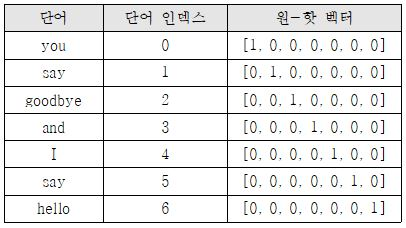

하나의 문장에서 각각의 단어들에 인덱스를 부여하고, 단어의 개수만큼 차원을 가지는 벡터를 생성합니다. 그리고 표현하고 싶은 단어에 대해서 해당 단어의 인덱스에는 1을 표시하고 나머지에는 0을 표시합니다.

원-핫 인코딩은 간단하고 직관적으로 텍스트 데이터를 인코딩할 수 있지만, 단어나 문자의 수가 늘어나면 벡터의 차원도 그만큼 늘어나고, 단어 간의 유사도를 표현할 수 없다는 단점을 가집니다.

In [7]:
# 입력 시퀀스에 대해서 원-핫 인코딩을 수행합니다
# 주의: 레이블 시퀀스에 대해서는 원-핫 인코딩을 수행하지 않습니다!

# np.eye -> 대각행렬 생성
x_one_hot = [np.eye(dic_size)[x] for x in x_data] #전체 25개 글자 중 해당 글자 인덱스에 맞춰 1 표시
X = torch.FloatTensor(x_one_hot) #32비트 부동소수점
Y = torch.LongTensor(y_data) #64비트 정수

<ipython-input-7-9215affc911e>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  X = torch.FloatTensor(x_one_hot)


In [10]:
# 훈련 데이터와 레이블의 shape를 출력해봅시다.
# 데이터가 정상적으로 처리됐다면 훈련 데이터는 [170, 10, 25], 레이블은 [170, 10]의 크기를 가집니다.

print('훈련 데이터의 크기 : {}'.format(X.shape))
print('레이블의 크기 : {}'.format(Y.shape))

훈련 데이터의 크기 : torch.Size([170, 10, 25])
레이블의 크기 : torch.Size([170, 10])


In [11]:
# 원-핫 인코딩이 잘 됐는지 첫 번째 샘플을 확인해봅시다.

print(X[0])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [12]:
# 레이블 데이터도 첫 번째 샘플을 확인해봅시다.

print(Y[0])

tensor([20,  6,  5,  8, 23,  6, 19, 13, 15, 17])


In [13]:
# RNN 모델 정의
# torch.nn.Module 클래스를 상속해서 Net이라는 새로운 사용자 정의 클래스를 만듭니다.

class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layers):        # 클래스의 인스턴스가 호출될 때 호출되는 생성자를 정의합니다.
        super(Net, self).__init__()                           # 부모 클래스인 torch.nn.Module의 생성자를 호출합니다.
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, num_layers=layers, batch_first=True)   # torch 내에 정의돼있는 RNN을 이용해 RNN의 레이어를 정의합니다.
        self.fc = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)    # fully connected layer로 출력층을 정의합니다.

    def forward(self, x):         # 구현한 RNN 셀과 출력층을 연결하는 메서드를 정의합니다.
        x, _status = self.rnn(x)  # input 값인 x를 RNN에 통과시킵니다.
        x = self.fc(x)            # RNN cell의 출력값을 fc에 통과시킵니다.
        return x

In [14]:
# RNN 층을 두 개 쌓아서 모델을 생성합니다.

net = Net(dic_size, hidden_size, 2)

In [15]:
# Loss function과 Optimizer를 선언합니다.

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), learning_rate)

In [16]:
# 방금 정의한 모델에 훈련 데이터를 통과시키고, 그 output의 크기를 출력해봅시다.
# 출력되는 3차원 텐서에서 각 요소는 순서대로 배치 차원, 시점(timesteps), 출력의 크기를 나타냅니다.

outputs = net(X)
print(outputs.shape) # 3차원 텐서

torch.Size([170, 10, 25])


In [17]:
# 정확도를 측정할 때는 3차원의 텐서를 모두 펼쳐서 계산하게 되는데, 이때는 view를 사용하여 배치 차원과 시점 차원을 하나로 만듭니다.

print(outputs.view(-1, dic_size).shape) # 2차원 텐서로 변환.

torch.Size([1700, 25])


In [19]:
# 레이블 데이터의 크기도 출력해봅니다.
# 레이블 데이터도 마찬가지로 나중에 정확도를 측정할 때는 이걸 펼쳐서 계산하게 됩니다. 이 때도 view를 사용하여 배치 차원과 시점 차원을 하나로 만듭니다.

print(Y.shape)
print(Y.view(-1).shape)

torch.Size([170, 10])
torch.Size([1700])


In [20]:
# 이제 모델을 학습시키고, 매 epoch마다 예측 결과를 출력해봅시다.

for i in range(300):
    optimizer.zero_grad()
    outputs = net(X) # (170, 10, 25) 크기를 가진 텐서를 매 epoch마다 모델의 입력으로 사용
    loss = criterion(outputs.view(-1, dic_size), Y.view(-1))
    loss.backward()
    optimizer.step()

    # results의 텐서 크기는 (170, 10)
    results = outputs.argmax(dim=2)
    predict_str = ""
    for j, result in enumerate(results):
        if j == 0: # 처음에는 예측 결과를 전부 가져오지만
            predict_str += ''.join([char_set[t] for t in result])
        else: # 그 다음에는 마지막 글자만 반복 추가
            predict_str += char_set[result[-1]]

    print(i, ': ', predict_str)

print("\nground truth:", sentence)

0 :  yyyypkypyp yypywyyykypyykyyyykpypyyyykyyyyyyypyyyyypoypyyyyypyyy yyyyypypoyyykyypyyyyyyyypyy yyyyyyykyypykypyyyyyoyyyyy yyyyyyyyyyyyyyyypyypypyypyy yyyypeyyyyyyw ypyyykypky yyyyyp
1 :                                                                                                                                                                                     
2 :   ntnnn nnn n  nna n nntn nn tntn n n n nn n n   nn nnn  n n  n n nn  tnn  tnn nntn n n  nn n  n nn n ntn  tnt   nnt  ntn n n  n  nntn tn n nn n n n  n n  tnn nnn nn n  n nn  nn  n
3 :  gyttyetghltltgttllgglggllgltgttltgltglltgtgtggtgtttlllglllllgttgttglggtgttgttgttttgltlglllgtgltggltgtgttglllgtgltggltltgttglgtttlttltgltgttgttglggtgtcgltlctgtlllglgtlgllggtgglgttg
4 :  o  tos tossssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss
5 :   tdeo tdotoootttotttttt tottooottotootott ttoott oototooo tt ottoto to

#**RNN 고장내기**

앞서 설명드렸듯이 RNN은 input 데이터가 길어질수록 앞쪽 내용을 잘 기억하지 못하게 됩니다. 그게 정말 사실인지 확인하기 위해 이번에는 긴 텍스트 데이터를 input으로 제공해서 RNN을 망가트려봅시다!

In [21]:
# 앞 과정을 반복해줍니다!

sentence_ = "long for the sea, my friend. it is boundless, wide, immense. do not stop to gather wood, do not stop to build a ship. instead, let the sea fill you with its vastness. let it sweep you away, let it set you free. no need for tasks, no need for assignments. the sea is what we need, not the ship. feel the infinity of the sea, its endless depth. let it be your guide, let it be your calling. it is not about building a ship, it is about the longing for the sea. the endless immensity of the sea is what we should long for. no need to drum up people, no need to assign them tasks. let them feel the sea, let them long for it. let them be free, let them be swept away by the immensity of the sea. the sea we long for, not the ship we build. so, let us embrace the sea, let us long for its endless immensity. let us go, my friends, let us go to the sea"
char_set_ = list(set(sentence_))
char_dic_ = {c: i for i, c in enumerate(char_set_)}
dic_size_ = len(char_dic_)

hidden_size_ = dic_size_
sequence_length = 10
learning_rate = 0.1

x_data_ = []
y_data_ = []

for i in range(0, len(sentence_) - sequence_length):
    x_str = sentence_[i:i + sequence_length]
    y_str = sentence_[i + 1: i + sequence_length + 1]

    x_data_.append([char_dic_[c] for c in x_str])
    y_data_.append([char_dic_[c] for c in y_str])

x_one_hot_ = [np.eye(dic_size_)[x] for x in x_data_]
X_ = torch.FloatTensor(x_one_hot_)
Y_ = torch.LongTensor(y_data_)

net_ = Net(dic_size_, hidden_size_, 2)

criterion_ = torch.nn.CrossEntropyLoss()
optimizer_ = optim.Adam(net_.parameters(), learning_rate)

In [22]:
for i in range(300):
    optimizer_.zero_grad()
    outputs = net_(X_)

    loss = criterion_(outputs.view(-1, dic_size_), Y_.view(-1))
    loss.backward()
    optimizer_.step()

    results = outputs.argmax(dim=2)
    predict_str = ""
    for j, result in enumerate(results):
        if j == 0:
            predict_str += ''.join([char_set_[t] for t in result])
        else:
            predict_str += char_set_[result[-1]]

    print(i, ': ', predict_str)

print("\nground truth:", sentence_)

0 :  llllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllalllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllallllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllallllllllllllllllllllllllllllalllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllalllillllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll
1 :  ssssssses essessss esssesssssssssssessssssssssssssssseessessssssss sessss ssss esssessssssssss sessss sssssssssseesssssse ssssses ssessesssssess

Reference: PyTorch로 시작하는 딥 러닝 입문 (https://wikidocs.net/64739)

# **과제**

### Q1. RNN의 장기 의존성(Long term dependency) 문제에 대해서 설명해주세요.

A1.
장기 의존성 문제란 은닉층의 과거 정보가 마지막까지 충분히 전달되지 못하고 중간에 소실되는 현상을 의미합니다. RNN에서의 장기 의존성 문제는 hidden state 값이 어떻게 계산되는지를 바탕으로 그 발생 원인을 파악할 수 있습니다. 

RNN의 hidden state는 아래와 같은 식을 통해 계산할 수 있습니다. 이 때 x^(t)는 embedding 입력값이며, h^(t-1)은 이전 시점의 hidden state 값, U와 W는 각각에 대한 가중치입니다. 

 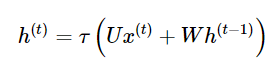

그런데, h^(t-1)의 식도 결국 h^(t-2)를 사용한 식으로 풀어 쓸 수 있기에, 현 시점 hidden state 값은 아래와 같은 계산식을 갖게 됩니다. 

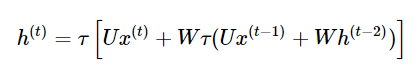

tanh 함수를 통과한 값은 -1 ~ 1 사이가 되고, 이 값이 연산 내에서 반복적으로 곱해지고 있음을 고려했을 때, feed-forward의 관점에서 뒷단으로 갈수록 앞의 정보를 충분히 전달할 수 없다는 문제가 생깁니다. 

더불어, RNN의 BPTT 과정에서 tanh 함수의 미분과 연쇄 법칙은 Gradient Vanishing (기울기 소실) 문제를 만들어 내기도 합니다. BPTT에서는 RNN의 가중치에 대한 손실 함수의 기울기를 계산하게 되는데, 그 수식은 아래와 같습니다. 

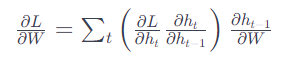
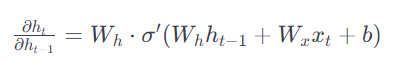

즉, loss를 계산하는 과정에서 h(t-1)에 대한 h(t)의 미분이 계속 곱해지고, 이 미분값은 0~1 사이의 값을 갖는 tanh 미분을 포함하고 있기 때문에, 시간을 거슬러 올라갈수록 기울기가 점점 더 작아져 Gradient vanishing 문제가 생기고, 결론적으로 가중치가 거의 업데이트 되지 않는 현상이 발생하게 되는 것입니다. 

### Q2. LSTM은 RNN의 기울기 소실 문제를 어떻게 해결했는지 간단하게 설명해주세요.

A2. RNN의 기울기 소실 문제는 tanh (혹은 그 미분값) 활성화 함수의 반복적인 연산에 의해 발생한 것입니다. LSTM은 Cell state와 Gate라는 개념을 도입해 RNN에서의 기울기 소실 문제를 해결하고자 한 모델입니다.

우선 LSTM의 기본 구조를 먼저 살펴보겠습니다. 
1) Cell state : 장기 기억을 저장하는 부분으로, 모델의 전체 체인을 지나며 일부 단순한 "선형적인 상호작용"만 진행합니다.
2) Gate : forget, input, output 총 3개의 gate로 이루어져 있으며, 각각의 gate는 다음과 같은 역할을 합니다.
- forget gate : 이전 hidden state 값과 현재 입력값을 반영한 활성화 함수 결과를 바탕으로 이전 정보 중 어떤 것을 잊을지 결정합니다.
- input gate : 이전 hidden state와 현재 입력값을 활성화 함수에 통과시켜 현재 입력값 중 업데이트 할 값을 결정합니다.
- output gate : 업데이트 된 cell state 중 어떤 값을 필터링해 출력할지 결정합니다. 
- 어떤 요소를 가져갈지 결정하는 과정과 cell state를 업데이트 하는 과정은 모두 element-wise 연산을 통해 이루어집니다. 

LSTM의 기본 구조 중 cell state는 각 time step에서 선형적인 상호작용만 진행하며 장기 기억을 보존합니다. 즉, 긴 시퀀스를 통과하며 기울기가 소멸하는 것을 방지하고, 이전의 정보가 끝까지 보존될 수 있게 돕습니다.

LSTM의 셀 상태 연산에서는 비선형 변환 (ex. tanh, sigmoid 등 비선형 활성화 함수 적용)이 최소화됩니다. 위에서 설명한 것처럼, cell state update나 gate와의 상호작용에서는 element-wise 방식으로 연산되기 때문입니다. 결국, 비선형 함수의 반복 연산으로 인해 값이 과도하게 작아지는 것을 방지할 수 있게 되는 것입니다.

한 가지 주의할 점은 LSTM이 Gradient vanishing 문제를 완전히 해결하고 있는 것은 아닙니다. 분명 RNN보다 기울기 소실 문제를 피하기 쉬운 구조는 맞지만, 비선형 활성화 함수가 사용되고, 역전파 과정에서 Chain rule이 적용된다는 점에서 여전히 gradient vanishing의 가능성은 존재하기 때문입니다. 